In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch
from scipy.special import softmax
from utils.funcs import *
from utils.data_utils import *
from src.models import *

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

Loading on device: cuda


In [2]:
# Define parameters
d = 5
var = 0.1
L = 40
n = 50000  # Number of iterations for averaging the loss

# list of omega from 0 to 1
L_ls = list(range(10, 101, 5))
loss_ls = []
omega = 0.13; mu = 3.45

# Loop over each value in omega_ls and mu_ls
for i in range(len(L_ls)):
    loss_temp_ls = [0,0,0,0,0]
        
    # Perform n iterations to average the loss
    for k in range(n):
        # Generate beta from a normal distribution
        beta = np.random.normal(0, 1/np.sqrt(d), d)
            
        # Generate data using the data_generator function
        X, y, xq, yq = data_generator(L_ls[i], d, beta, var)
            
        # Calculate the loss for the TF_Est estimator and accumulate it
        TF_Est = TFEst(L=L_ls[i], d=d, var=var) 
        loss_temp_ls[0] += (TF_Est.Est(X, y, xq, omega * np.array([1, -1]), mu *  np.array([1, -1])) - yq) ** 2
        loss_temp_ls[2] += (TF_Est.GDEst(X, y, xq, omega, mu) - yq) ** 2
        loss_temp_ls[3] += (TF_Est.DGDEst(X, y, xq, omega, mu) - yq) ** 2
        #loss_temp_ls[3] += (TF_Est.Est(X, y, xq, 0.5177*  np.array([1]), 1.5523 * np.array([1])) - yq) ** 2
        loss_temp_ls[1] += (TF_Est.Est(X, y, xq, 1/np.sqrt(d)*  np.array([1]), np.sqrt(d)/(1+(1+var)*d/L*math.e)*  np.array([1])) - yq) ** 2
        loss_temp_ls[4] += (TF_Est.RidgeEst(X, y, xq) - yq) ** 2
        
    # Average the accumulated losses and store them
    for j in range(5): loss_temp_ls[j] = loss_temp_ls[j]/n
    loss_ls.append(loss_temp_ls)
        
    # Print the results for the current omega and mu
    print(f"L: {L_ls[i]}, loss: {loss_ls[i][0]}, gd loss: {loss_ls[i][2]}, dgd loss: {loss_ls[i][3]}, kernel loss: {loss_ls[i][1]}, ridge loss: {loss_ls[i][4]}")

L: 10, loss: 0.603916889800451, gd loss: 0.643425682959232, dgd loss: 0.6139782717489936, kernel loss: 0.8753977014216452, ridge loss: 0.19381625962190976
L: 15, loss: 0.44860545480156877, gd loss: 0.46110118885215745, dgd loss: 0.45319551902833455, kernel loss: 0.6911165395002169, ridge loss: 0.1510276537423532
L: 20, loss: 0.367479242173692, gd loss: 0.37088985741919467, dgd loss: 0.3692424042650245, kernel loss: 0.5858538127219645, ridge loss: 0.1345614704400968
L: 25, loss: 0.31707549046090333, gd loss: 0.3180292553054342, dgd loss: 0.3180310810039968, kernel loss: 0.5204333531673379, ridge loss: 0.12450006794092099
L: 30, loss: 0.28643557951665244, gd loss: 0.28491137262756705, dgd loss: 0.28671562348553475, kernel loss: 0.47112596002422846, ridge loss: 0.12147448169740922
L: 35, loss: 0.26181026251668743, gd loss: 0.25928141728957954, dgd loss: 0.26182474045500226, kernel loss: 0.4318635301708191, ridge loss: 0.11643091539520474
L: 40, loss: 0.2430439318613147, gd loss: 0.2407496

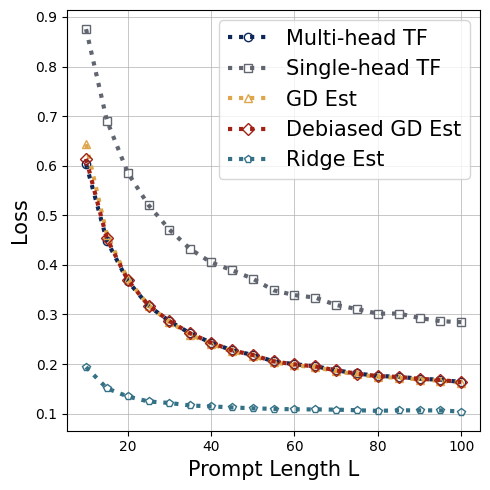

In [3]:
# Define colors, labels, and markers for the lines
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
labels = ['Multi-head TF', 'Single-head TF', 'GD Est', 'Debiased GD Est', 'Ridge Est']
markers = ['o', 's', '^', 'D', 'p']  # Circle, square, triangle, diamond

# Create the plot
plt.figure(figsize=(5, 5))
for idx in range(5):
    # Plot with dotted lines and empty markers
    plt.plot(L_ls, [loss[idx] for loss in loss_ls], color=colors[idx], linestyle=':', linewidth=3,
             marker=markers[idx], markersize=6, markerfacecolor='none', markeredgecolor=colors[idx], label=labels[idx])

# Customize the plot
plt.xlabel('Prompt Length L', fontsize=15)
plt.ylabel('Loss', fontsize=15)
#plt.title('Loss vs L for Different Estimators', fontsize=14)
plt.legend(fontsize=15, loc='upper right')
plt.grid(True, linestyle='-', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF and display it
plt.savefig("Est_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
# Define parameters
n = 50000  # Number of iterations for averaging the loss

xi = 0.2; L = 100; d=int(L*xi); var = 3
eta = 0.5/(xi*(1+var)+1)
loss_gd = 0
loss_ridge = 0


# Perform n iterations to average the loss
for k in range(n):
    # Generate beta from a normal distribution
    beta = np.random.normal(0, 1/np.sqrt(d), d)
            
    # Generate data using the data_generator function
    X, y, xq, yq = data_generator(L, d, beta, var)
            
    # Calculate the loss for the TF_Est estimator and accumulate it
    TF_Est = TFEst(L=L, d=d, var=var) 
    loss_gd += (TF_Est.GDEst(X, y, xq, 1, eta) - yq) ** 2
    loss_ridge += (TF_Est.RidgeEst(X, y, xq) - yq) ** 2
        
# Print the results for the current omega and mu
print(f"gd loss: {loss_gd/n}, ridge loss: {loss_ridge/n}")

gd loss: 3.4419300165903843, ridge loss: 3.403764825571806


In [5]:
# Define the list of values for `n_head`
n_head_ls = [1, 2, 4, 8]  # Example values for `n_head`
n_layers = 1  # Fixed number of layers
d = 5  # Fixed value for `d`
device = 'cpu'  # Replace with 'cuda' if using GPU

# Initialize a list to store error lists for each model
all_model_errors = []

# Loop through each value in `n_head_ls`
for n_head in n_head_ls:
    n_sam = 100000 if n_head == 1 else 20000
    try:
        # Define the model path
        model_path = f"saved_models/Layer_{n_layers}_Head_{n_head}_d_{d}_trained_model.pth"
        
        # Load the model state_dict
        model_head_1_load = torch.load(model_path, map_location=torch.device(device), weights_only=False)
        model_head_1 = model_head_1_load['model']  # Assuming the model is saved under the key 'model'
        
        # Create the model architecture
        model = MultiHeadAttentionStack(n_layers, d + 1, n_head, 1, False)
        model.load_state_dict(model_head_1, strict=True)
        model.eval()  # Set the model to evaluation mode
        
        # Initialize a list to store errors for different `L` values for this model
        model_errors = []

        # Loop through `new_L` values
        for new_L in range(10, 101, 5):
            # Generate new data with varying `L`
            evaluate_kernel_data = LinearReg({
                "L": new_L,
                "dx": d,
                "dy": 1,
                "number_of_samples": n_sam,
                "noise_std": np.sqrt(0.1)
            })
            
            # Generate the data
            zs_q, zs, ys_q = evaluate_kernel_data.__generatedata__()
            
            # Ensure data is on the same device as the model
            zs_q, zs, ys_q = zs_q.to(device), zs.to(device), ys_q.to(device)

            # Compute the model's output
            method_output = model(zs_q, zs).squeeze(-1)

            # Compute the error using MSELoss
            loss_func = torch.nn.MSELoss()
            error = loss_func(method_output, ys_q.squeeze(-1)).item() + 0.1
            model_errors.append(error)

        # Append the error list for this model to the main list
        all_model_errors.append(model_errors)

        print(f"Errors for n_head={n_head}: {model_errors}")

    except Exception as e:
        print(f"Failed to evaluate model for n_head={n_head}. Error: {e}")
        all_model_errors.append([])  # Append an empty list for models that failed

# Print the full list of errors
print("All model errors:", all_model_errors)


Errors for n_head=1: [0.9468536138534546, 0.7747003197669983, 0.6744256377220154, 0.6079615116119385, 0.56534663438797, 0.5290741086006164, 0.5060214757919311, 0.48306152820587156, 0.4628159761428833, 0.44949874877929685, 0.43754655718803404, 0.42611483335494993, 0.41904363632202146, 0.40983054637908933, 0.4046556711196899, 0.39400473833084104, 0.38619703650474546, 0.38308326005935667, 0.3808830738067627]
Errors for n_head=2: [0.679072892665863, 0.5388866126537323, 0.4655915558338165, 0.422527676820755, 0.3811595499515533, 0.3581493258476257, 0.3409829795360565, 0.32949907183647154, 0.31813245117664335, 0.30896074175834654, 0.3024072706699371, 0.28979932367801664, 0.2878400295972824, 0.283853805065155, 0.2819174587726593, 0.28015843629837034, 0.27082339525222776, 0.2692061126232147, 0.2684938222169876]
Errors for n_head=4: [0.6726825594902038, 0.5484489858150482, 0.463650768995285, 0.4114819824695587, 0.3802704870700836, 0.36151922345161436, 0.3448071539402008, 0.32990547120571134, 0.3

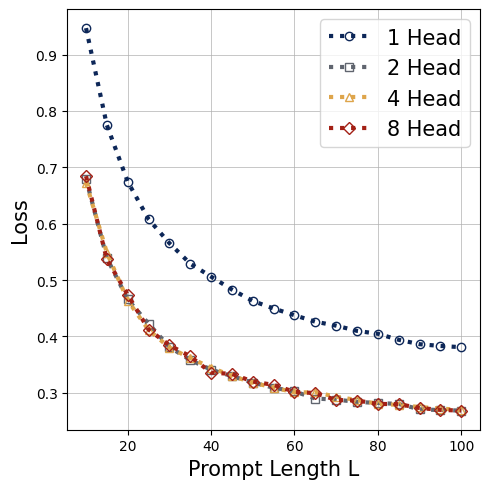

In [6]:
# Define colors, labels, and markers for the lines
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
labels = [f'{n_head} Head' for n_head in n_head_ls]
markers = ['o', 's', '^', 'D', 'p'] 

# Create the plot
plt.figure(figsize=(5, 5))
for idx in range(len(all_model_errors)):
    # Plot with dotted lines and empty markers
    plt.plot(
        range(10, 101, 5), all_model_errors[idx], 
        color=colors[idx], linestyle=':', linewidth=3,
        marker=markers[idx], markersize=6, markerfacecolor='none',
        markeredgecolor=colors[idx], label=labels[idx]
    )

# Customize the plot
plt.xlabel('Prompt Length L', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=15, loc='upper right')
plt.grid(True, linestyle='-', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF and display it
plt.savefig("Head_num_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Load the .pth file
n_layers, d, n_head = 1,5,2
model_path = f"saved_models/Layer_{n_layers}_Head_{n_head}_d_{d}_trained_model.pth"
model_head_1_load = torch.load(model_path, map_location=torch.device(device), weights_only=True)
model_head_1 = model_head_1_load['model']

extract_kq_ov_details(model_head_1, 6, n_head)

{'avg_diag_norm_ratio': 0.9992583856390247,
 'avg_diag_variance': 3.283092191139758e-06,
 'avg_last_entry_square_ratio': 0.999937891960144}

## Plot Dynamics of Trained One-Layer Transformer

In [7]:
def plot_attn_matrices(model, n_layers, d, n_head, adj_factor = [1,1], dy = 1, save = False):
    """
    Plots the Query-Key (QK) and Output-Value (OV) matrices for multiple attention heads, combining QK and OV
    for each head in a single plot with a subplot layout (size ratio 4:1).

    Parameters:
    - model: dict
        A dictionary containing the weights of the attention layer. Expected keys include:
        - 'attention_layer.q_proj.weight': Query projection weight matrix of shape (d_embed * n_head, d_embed).
        - 'attention_layer.k_proj.weight': Key projection weight matrix of shape (d_embed * n_head, d_embed).
        - 'attention_layer.v_proj.weight': Value projection weight matrix of shape (d_embed * n_head, d_embed).
        - 'attention_layer.o_proj.weight': Output projection weight matrix of shape (d_embed, d_embed * n_head).
    - d: int
        Dimensionality of the model (base size \(d\), where \(d_embed = d + 1\)).
    - n_head: int
        Number of attention heads.

    Returns:
    - None
        Displays each head's QK and OV plots in separate figures.
    """
    # Adjust embedding size to account for d + 1
    d_embed = d + dy

    # Extract projection matrices
    W_Q = model['attention_layer.q_proj.weight']  # Shape: (d_embed * n_head, d_embed)
    W_K = model['attention_layer.k_proj.weight']  # Shape: (d_embed * n_head, d_embed)
    W_V = model['attention_layer.v_proj.weight']  # Shape: (d_embed * n_head, d_embed)
    W_O = model['attention_layer.o_proj.weight']  # Shape: (d_embed, d_embed * n_head)

    # Ensure the embedding size is consistent with the number of heads
    assert W_Q.shape[0] == d_embed * n_head, f"Expected W_Q rows to match {d_embed * n_head}, but got {W_Q.shape[0]}"
    assert W_Q.shape[1] == d_embed, f"Expected W_Q columns to match {d_embed}, but got {W_Q.shape[1]}"

    for head_idx in range(n_head):
        # Slice the weights for this head
        W_Q_h = W_Q[head_idx * d_embed:(head_idx + 1) * d_embed, :]  # Shape: (d_embed, d_embed)
        W_K_h = W_K[head_idx * d_embed:(head_idx + 1) * d_embed, :]  # Transpose: Shape (d_embed, d_embed)
        W_V_h = W_V[head_idx * d_embed:(head_idx + 1) * d_embed, :]  # Shape: (d_embed, d_embed)
        W_O_h = W_O[:, head_idx * d_embed:(head_idx + 1) * d_embed]  # Shape: (d_embed, d_embed)

        # Compute QK and OV matrices
        QK = (W_K_h.T @ W_Q_h) / np.sqrt(d_embed)  # Scaled QK matrix
        OV = W_V_h.T @ W_O_h.T  # OV matrix

        QK_np = QK.cpu().detach().numpy() if hasattr(QK, 'cpu') else QK
        OV_np = OV.cpu().detach().numpy() if hasattr(OV, 'cpu') else OV
        #print(QK_np)

        QK_max_abs_value = np.abs(QK_np).max() * adj_factor[0]
        OV_max_abs_value = np.abs(OV_np).max() * adj_factor[1]

        # Create a single figure with two subplots for QK and OV
        fig, (ax_qk, ax_ov) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [8, 1]})

        # Adjust spacing between plots
        plt.subplots_adjust(wspace=-0.4)

        # --- Plot QK Matrix ---
        im_qk = ax_qk.imshow(QK_np, cmap=cividis_with_white, 
                             vmax = QK_max_abs_value, vmin = - QK_max_abs_value, 
                             aspect='equal', interpolation='none')
        ax_qk.set_title(f'Head {head_idx + 1} QK', fontsize=17)
        fig.colorbar(im_qk, pad=0.04)
        # Add green dotted lines to QK plot
        ax_qk.axvline(x=d-0.5, color='green', linestyle='--', linewidth=5)  # Vertical line
        ax_qk.axhline(y=d-0.5, color='green', linestyle='--', linewidth=5)  # Horizontal line

        # --- Plot OV Matrix ---
        im_ov = ax_ov.imshow(OV_np, cmap=cividis_with_white, 
                             vmax = OV_max_abs_value, vmin = - OV_max_abs_value, 
                             aspect='equal', interpolation='none')
        ax_ov.set_title(f'Head {head_idx + 1} OV', fontsize=17)
        ax_ov.set_xticks([])  # Remove x-axis measures
        fig.colorbar(im_ov, pad=0.3, aspect=25, shrink=1)
        ax_ov.axhline(y=d-0.5, color='green', linestyle='--', linewidth=5)  # Horizontal line

        plt.tight_layout()
        plt.show()
        if save:
            fig.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_attnmtrx_HeadId{head_idx+1}.pdf", format="pdf", bbox_inches='tight')

def plot_heatmap_sequence_all_heads(tensor_list, indices, training_step, adj_factor=1, save=False):
    """
    Plots a sequence of heatmaps for all heads at specified steps, sharing a single color bar.

    Parameters:
    - tensor_list (list of lists): A list of size (n_head, n_step), where each element is a tensor matrix.
    - indices (list of int): List of indices (steps) specifying which matrices to plot for all heads.
    - training_step (int): Total number of training steps.

    Returns:
    - None
    """
    n_head = len(tensor_list)  # Number of heads
    n_step = len(tensor_list[0]) if n_head > 0 else 0  # Number of steps per head

    # Extract matrices for all heads and valid steps
    all_matrices = []
    for head_idx in range(n_head):
        head_matrices = [tensor_list[head_idx][i].cpu().detach().numpy() for i in indices]
        all_matrices.extend(head_matrices)

    # Compute global color scale
    vmax = max(np.max(matrix) for matrix in all_matrices) * adj_factor

    # Create subplots
    fig, axes = plt.subplots(
        n_head, len(indices), figsize=(5 * len(indices), 5 * n_head),
        sharex=True, sharey=True, squeeze=False
    )

    # Plot each heatmap
    for head_idx in range(n_head):
        for plot_idx, step_idx in enumerate(indices):
            matrix = tensor_list[head_idx][step_idx]
            matrix = matrix.cpu().detach().numpy() if isinstance(matrix, torch.Tensor) else matrix
            ax = axes[head_idx][plot_idx]
            im = ax.imshow(matrix.T, cmap=cividis_with_white, aspect="equal", vmin=-vmax, vmax=vmax)

            # Add titles and labels
            if head_idx == 0:
                if step_idx != 0:
                    ax.set_title(f"Step {int(step_idx / (n_step-1) * training_step / 1000)}k", fontsize=22)
                else:
                    ax.set_title(f"Step 1", fontsize=22)
            if plot_idx == 0:
                ax.set_ylabel(f"Head {head_idx + 1} KQ", fontsize=22)

    # Add a single shared color bar
    cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02, shrink=0.96)

    plt.show()
    if save:
            fig.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_attnmtrx_dynamic.pdf", format="pdf", bbox_inches='tight')

def plot_heatmap_sequence_per_head(tensor_list, indices, training_step, adj_factor=1, save=False):
    """
    Plots a sequence of heatmaps for each head in separate figures.

    Parameters:
    - tensor_list (list of lists): A list of size (n_head, n_step), where each element is a tensor matrix.
    - indices (list of int): List of indices (steps) specifying which matrices to plot for all heads.
    - training_step (int): Total number of training steps.
    - adj_factor (float): Adjustment factor for the color scale.
    - save (bool): Whether to save each figure as a PDF.

    Returns:
    - None
    """
    n_head = len(tensor_list)  # Number of heads
    n_step = len(tensor_list[0]) if n_head > 0 else 0  # Number of steps per head

    # Compute global color scale
    all_matrices = []
    for head_idx in range(n_head):
        head_matrices = [tensor_list[head_idx][i].cpu().detach().numpy() for i in indices]
        all_matrices.extend(head_matrices)
    vmax = max(np.max(matrix) for matrix in all_matrices) * adj_factor

    for head_idx in range(n_head):
        # Create a figure for each head
        fig, axes = plt.subplots(
            1, len(indices), figsize=(5 * len(indices)/2, 5), sharex=True, sharey=True, squeeze=False
        )
        plt.subplots_adjust(wspace=0.01)

        # Plot heatmaps for the current head
        for plot_idx, step_idx in enumerate(indices):
            matrix = tensor_list[head_idx][step_idx]
            matrix = matrix.cpu().detach().numpy() if isinstance(matrix, torch.Tensor) else matrix
            ax = axes[0][plot_idx]
            im = ax.imshow(matrix, cmap=cividis_with_white, aspect="equal", vmin=-vmax, vmax=vmax)

            # Add titles and labels
            if step_idx != 0:
                ax.set_title(f"Step {int(step_idx / (n_step-1) * training_step/1000)}k", fontsize=22)
            else:
                ax.set_title(f"Step 1", fontsize=22)

        axes[0][0].set_ylabel(f"Head {head_idx + 1} OV", fontsize=22)

        # Add a single shared color bar for this head
        cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.1, shrink=1)

        # Show or save the figure
        plt.show()
        if save:
            fig.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_attnmtrx_dynamic_HeadId{head_idx+1}.pdf", format="pdf", bbox_inches="tight")

In [8]:
# Load the .pth file
n_layers, d, n_head = 1,5,1
model_path = f"saved_models/Layer_{n_layers}_Head_{n_head}_d_{d}_trained_model.pth"
model_head_1_load = torch.load(model_path, map_location=torch.device(device), weights_only=True)
model_head_1 = model_head_1_load['model']

print(f"Keys of Saved Data: {model_head_1_load.keys()}")
print(f"Keys of Saved Model: {model_head_1_load['model'].keys()}")

Keys of Saved Data: dict_keys(['final_loss', 'training_losses', 'validation_losses', 'qk_dynamics', 'ov_dynamics', 'qk_matrices', 'model'])
Keys of Saved Model: odict_keys(['attention_layer.q_proj.weight', 'attention_layer.k_proj.weight', 'attention_layer.v_proj.weight', 'attention_layer.o_proj.weight'])


/tmp/ipykernel_543107/658360533.py:64: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im_qk, pad=0.04)


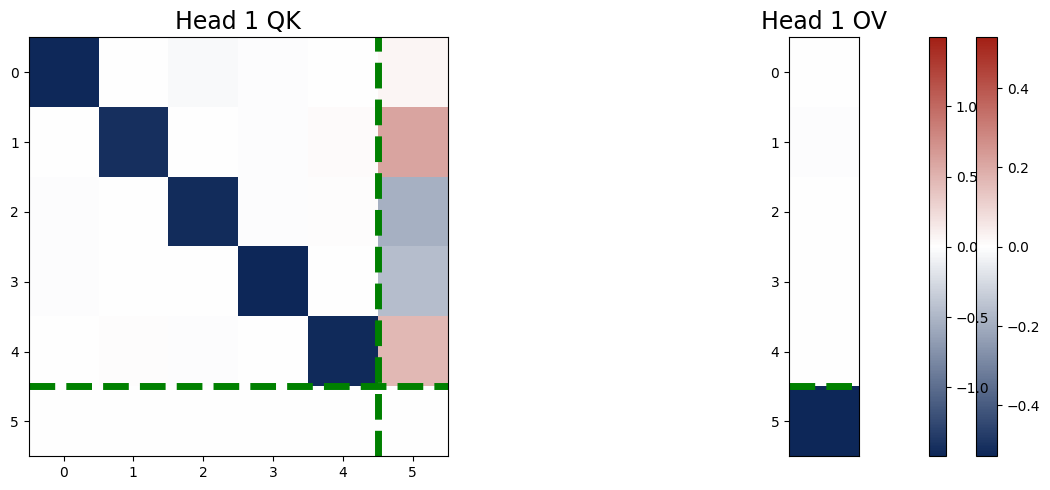

In [9]:
plot_attn_matrices(model_head_1, n_layers, d, n_head, adj_factor = [1,1], save=True)

In [11]:
# Load the .pth file
n_layers, d, n_head = 1,5,2
model_path = "saved_models/Layer_1_Head_2_d_5_trained_model.pth"
model_head_2_load = torch.load(model_path, map_location=torch.device(device), weights_only=True)
model_head_2 = model_head_2_load['model']

print(f"Keys of Saved Data: {model_head_2_load.keys()}")
print(f"Keys of Saved Model: {model_head_2_load['model'].keys()}")

Keys of Saved Data: dict_keys(['final_loss', 'training_losses', 'validation_losses', 'qk_dynamics', 'ov_dynamics', 'qk_matrices', 'model'])
Keys of Saved Model: odict_keys(['attention_layer.q_proj.weight', 'attention_layer.k_proj.weight', 'attention_layer.v_proj.weight', 'attention_layer.o_proj.weight'])


### Plot the Attention Matrix of Trained Model

/tmp/ipykernel_543107/658360533.py:64: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im_qk, pad=0.04)


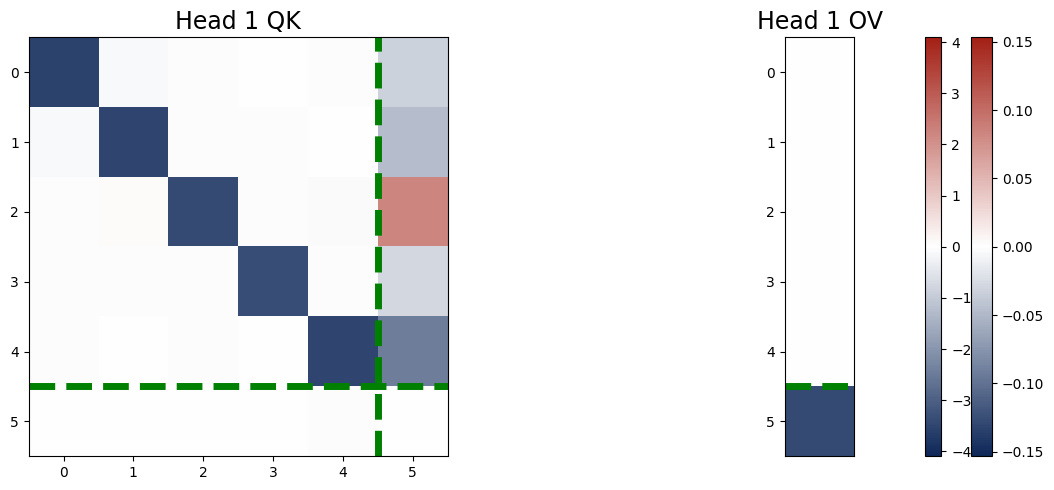

/tmp/ipykernel_543107/658360533.py:64: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im_qk, pad=0.04)


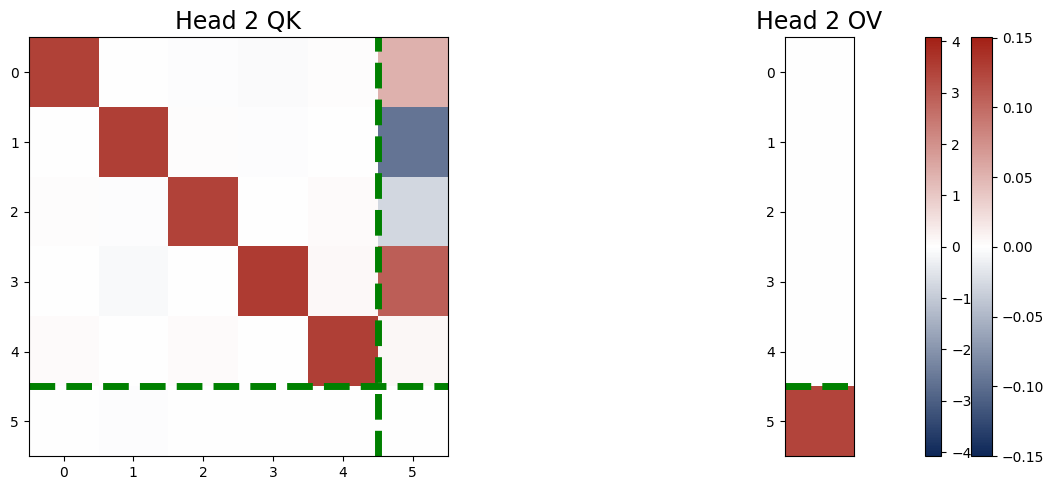

In [12]:
plot_attn_matrices(model_head_2, n_layers, d, n_head, [1.15,1.2], save=True)

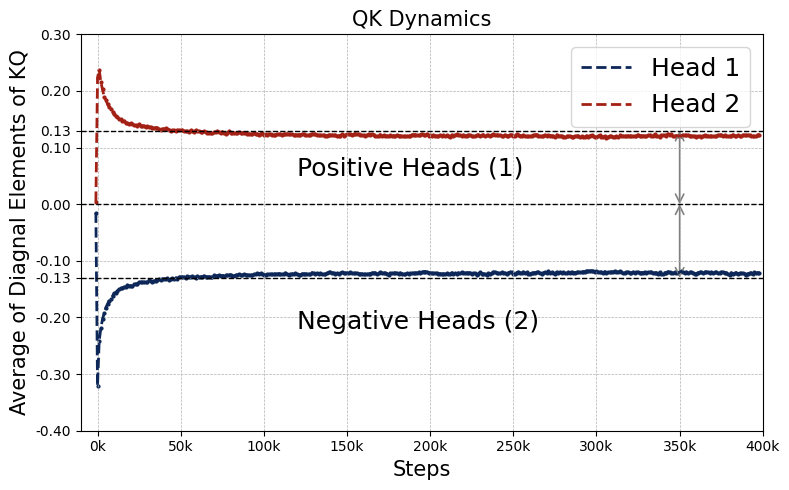

In [13]:
colors= ['#0D2758','#A32015', "#60656F", "#DEA54B"]

# Create the figure
plt.figure(figsize=(8, 5))

for idx, dynamics_list in enumerate(model_head_2_load['qk_dynamics']):
    # Convert to NumPy array
    data = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in dynamics_list][:400]
    x = [(i-1) * 400000 / len(data)  for i in range(len(data))]
    
    # Plot the points (small markers) and lines
    plt.plot(x, data, color=colors[idx], linestyle='--', linewidth=2, label=f'Head {idx + 1}')
    plt.scatter(x, data, color=colors[idx], s=4, marker='o')  # Smaller points
    
# Add horizontal reference line
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.13, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.13, color='black', linestyle='--', linewidth=1)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(350000, 0.135),  # Start position (x, y)
    posB=(350000, -0.005),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(350000, -0.135),  # Start position (x, y)
    posB=(350000, 0.005),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Customize x-axis ticks
xticks = np.linspace(0, 400000, num=9)  # Generate ticks (e.g., 0, 100000, 200000, ...)
plt.xticks(ticks=xticks, labels=[f'{int(tick/1000)}k' for tick in xticks])

# Customize y-axis ticks
yticks = plt.yticks()[0]
plt.yticks(ticks=np.append(yticks, [0.13, -0.13]), labels=[f'{tick:.2f}' if tick in [0.13, -0.13] else f'{tick:.2f}' for tick in np.append(yticks, [0.13, -0.13])])

plt.text(120000, 0.05, "Positive Heads (1)", fontsize=18, color="black")
#plt.text(180000, 0.03, "Dummy Heads (3)", fontsize=15, color="black")
plt.text(120000, -0.22, "Negative Heads (2)", fontsize=18, color="black")

# Add labels, title, and legend
plt.xlim(-10000, 400000)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average of Diagnal Elements of KQ', fontsize=15)
plt.title('QK Dynamics', fontsize=15)
plt.legend(fontsize=18, loc ="upper right")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_kq_dynamic.pdf", format="pdf", bbox_inches="tight")
plt.show()

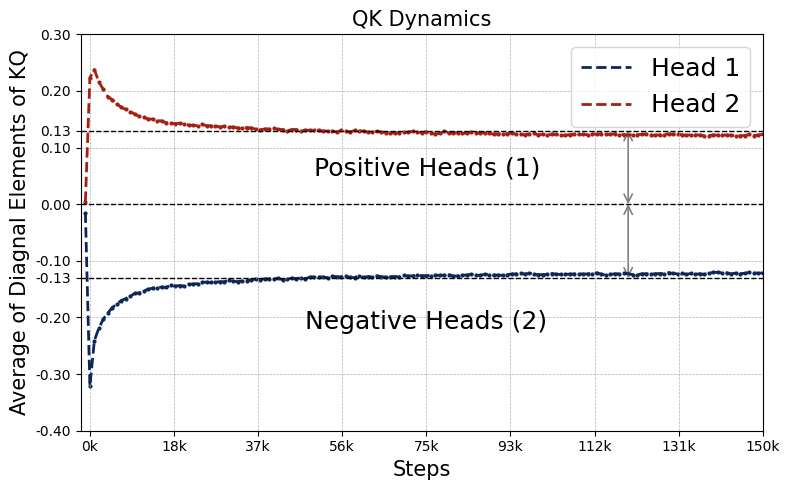

In [14]:
colors= ['#0D2758','#A32015', "#60656F", "#DEA54B"]

# Create the figure
plt.figure(figsize=(8, 5))

for idx, dynamics_list in enumerate(model_head_2_load['qk_dynamics']):
    # Convert to NumPy array
    data = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in dynamics_list][:200]
    x = [(i-1) * 200000 / len(data)  for i in range(len(data))]
    
    # Plot the points (small markers) and lines
    plt.plot(x, data, color=colors[idx], linestyle='--', linewidth=2, label=f'Head {idx + 1}')
    plt.scatter(x, data, color=colors[idx], s=4, marker='o')  # Smaller points

# Add horizontal reference line
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.13, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-0.13, color='black', linestyle='--', linewidth=1)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(120000, 0.135),  # Start position (x, y)
    posB=(120000, -0.005),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(120000, -0.135),  # Start position (x, y)
    posB=(120000, 0.005),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Customize x-axis ticks
xticks = np.linspace(0, 150000, num=9)  # Generate ticks (e.g., 0, 100000, 200000, ...)
plt.xticks(ticks=xticks, labels=[f'{int(tick/1000)}k' for tick in xticks])

# Customize y-axis ticks
yticks = plt.yticks()[0]
plt.yticks(ticks=np.append(yticks, [0.13, -0.13]), labels=[f'{tick:.2f}' if tick in [0.13, -0.13] else f'{tick:.2f}' for tick in np.append(yticks, [0.13, -0.13])])

plt.text(50000, 0.05, "Positive Heads (1)", fontsize=18, color="black")
#plt.text(180000, 0.03, "Dummy Heads (3)", fontsize=15, color="black")
plt.text(48000, -0.22, "Negative Heads (2)", fontsize=18, color="black")

# Add labels, title, and legend
plt.xlim(-2000, 150000)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average of Diagnal Elements of KQ', fontsize=15)
plt.title('QK Dynamics', fontsize=15)
plt.legend(fontsize=18, loc ="upper right")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_kq_dynamic_main.pdf", format="pdf", bbox_inches="tight")
plt.show()

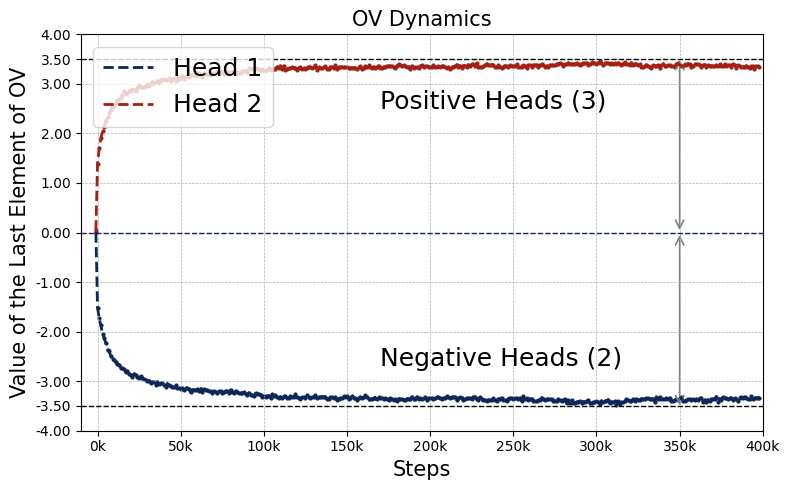

In [15]:
# Create the figure
plt.figure(figsize=(8, 5))
sum_negative = []

for idx, dynamics_list in enumerate(model_head_2_load['ov_dynamics']):
    # Convert to NumPy array
    data = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in dynamics_list][:400]
    x = [(i-1) * 400000 / len(data) for i in range(len(data))]
    #if idx == 0 or idx ==3:
    #    sum_negative.append(data)
    
    # Plot the points (small markers) and lines
    plt.plot(x, data, color=colors[idx], linestyle='--', linewidth=2, label=f'Head {idx + 1}')
    plt.scatter(x, data, color=colors[idx], s=4, marker='o')  # Smaller points

#sum_negative = [sum_negative[0][i] + sum_negative[1][i] for i in range(len(sum_negative[0]))]
#plt.plot(x, sum_negative, color="#AD8A64", linestyle=':', linewidth=2, label=f'Sum of Head 1&4')
#plt.scatter(x, sum_negative, color="#AD8A64", s=4, marker='o')  # Smaller points
    
# Add horizontal reference line
plt.axhline(y=0, color='#0D2758', linestyle='--', linewidth=1)
plt.axhline(y=3.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-3.5, color='black', linestyle='--', linewidth=1)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(350000, 3.55),  # Start position (x, y)
    posB=(350000, -0.01),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(350000, -3.55),  # Start position (x, y)
    posB=(350000, 0.01),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

plt.text(170000, 2.5, "Positive Heads (3)", fontsize=18, color="black")
#plt.text(180000, 0.3, "Dummy Heads (1)", fontsize=15, color="black")
plt.text(170000, -2.7, "Negative Heads (2)", fontsize=18, color="black")

xticks = np.linspace(0, 400000, num=9)  # Generate ticks (e.g., 0, 100000, 200000, ...)
plt.xticks(ticks=xticks, labels=[f'{int(tick/1000)}k' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(ticks=np.append(yticks, [3.5, -3.5]), labels=[f'{tick:.2f}' if tick in [3.5, -3.5] else f'{tick:.2f}' for tick in np.append(yticks, [3.5, -3.5])])
# Add labels, title, and legend
plt.xlim(-10000, 400000)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Value of the Last Element of OV', fontsize=15)
plt.title('OV Dynamics', fontsize=15)
plt.legend(fontsize=18, loc ="upper left")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_ov_dynamic.pdf", format="pdf", bbox_inches="tight")
plt.show()

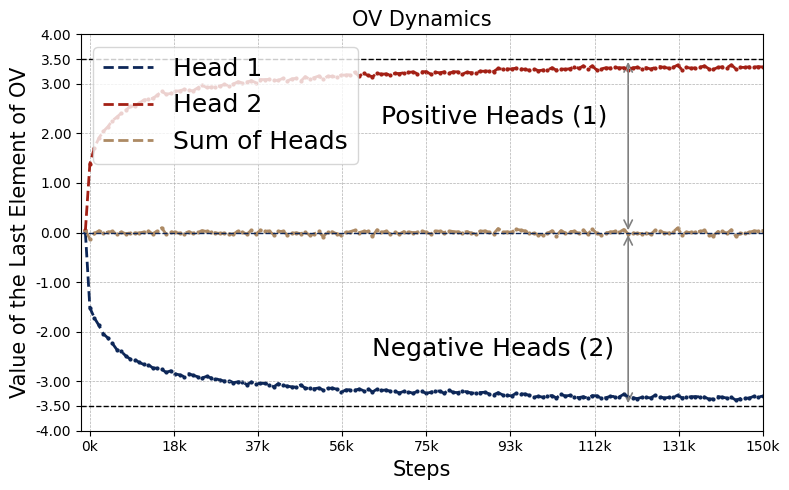

In [16]:
# Create the figure
plt.figure(figsize=(8, 5))
sum_negative = []

for idx, dynamics_list in enumerate(model_head_2_load['ov_dynamics']):
    # Convert to NumPy array
    data = [x.cpu().detach().numpy() if isinstance(x, torch.Tensor) else x for x in dynamics_list][:400]
    x = [(i-1) * 400000 / len(data) for i in range(len(data))]
    if idx == 0 or idx ==1:
        sum_negative.append(data)
    
    # Plot the points (small markers) and lines
    plt.plot(x, data, color=colors[idx], linestyle='--', linewidth=2, label=f'Head {idx + 1}')
    plt.scatter(x, data, color=colors[idx], s=4, marker='o')  # Smaller points

sum_negative = [sum_negative[0][i] + sum_negative[1][i] for i in range(len(sum_negative[0]))]
plt.plot(x, sum_negative, color="#AD8A64", linestyle='--', linewidth=2, label=f'Sum of Heads')
plt.scatter(x, sum_negative, color="#AD8A64", s=4, marker='o')  # Smaller points
    
# Add horizontal reference line
plt.axhline(y=0, color='#0D2758', linestyle='--', linewidth=1)
plt.axhline(y=3.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-3.5, color='black', linestyle='--', linewidth=1)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(120000, 3.5),  # Start position (x, y)
    posB=(120000, -0.01),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

# Add a double arrow
arrow = FancyArrowPatch(
    posA=(120000, -3.5),  # Start position (x, y)
    posB=(120000, 0.01),  # End position (x, y)
    arrowstyle='<->',  # Double-headed arrow
    mutation_scale=15,  # Size of the arrow
    color='gray',  # Color of the arrow
    linewidth=1.2,  # Line width
)
plt.gca().add_patch(arrow)

plt.text(65000, 2.2, "Positive Heads (1)", fontsize=18, color="black")
#plt.text(180000, 0.03, "Dummy Heads (3)", fontsize=15, color="black")
plt.text(63000, -2.5, "Negative Heads (2)", fontsize=18, color="black")

xticks = np.linspace(0, 150000, num=9)  # Generate ticks (e.g., 0, 100000, 200000, ...)
plt.xticks(ticks=xticks, labels=[f'{int(tick/1000)}k' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(ticks=np.append(yticks, [3.5, -3.5]), labels=[f'{tick:.2f}' if tick in [3.5, -3.5] else f'{tick:.2f}' for tick in np.append(yticks, [3.5, -3.5])])

# Add labels, title, and legend
plt.xlim(-2000, 150000)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Value of the Last Element of OV', fontsize=15)
plt.title('OV Dynamics', fontsize=15)
plt.legend(fontsize=18, loc ="upper left")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"Layer_{n_layers}_Head_{n_head}_d_{d}_ov_dynamic_main.pdf", format="pdf", bbox_inches="tight")
plt.show()